<a href="https://colab.research.google.com/github/Gogulaanand/Fault-Diagnosis/blob/master/Fault%20Diagnosis_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import io
import tensorflow as tf
from tensorflow.python.framework import ops
import math
import h5py

%matplotlib inline
np.random.seed(1)


In [4]:
from google.colab import files
uploaded = files.upload()

Saving projdata.csv to projdata.csv
Saving projdata_test_set.csv to projdata_test_set.csv


In [0]:
df=pd.read_csv(io.StringIO(uploaded['projdata.csv'].decode("utf-8")),engine='python',sep=",")
df1=pd.read_csv(io.StringIO(uploaded['projdata_test_set.csv'].decode("utf-8")),engine='python',sep=",")

ds=df.sample(frac=1)
ds1=df1.sample(frac=1)


In [0]:
Y_train=np.array(df[['Fault']]).T
X_train=ds.as_matrix(columns=df.columns[1:]).T
X_test=ds1.as_matrix(columns=df1.columns[1:]).T
Y_test=np.array(df1[['Fault']]).T
a=X_train
b=Y_train
c=X_test
d=Y_test
# X_train=tf.constant(X_train,name="X_train",dtype=tf.float64)
# Y_train=tf.constant(Y_train,name="Y_train",dtype=tf.float64)
# X_test=tf.constant(X_test,name="X_test",dtype=tf.float64)
# Y_test=tf.constant(Y_test,name="Y_test",dtype=tf.int64)


In [7]:
nx=np.min(np.shape(X_train))
ny=np.min(np.shape(Y_train))
nh=3
nl=2
print("Size of input layer: "+str(nx))
print("Size of output layer: "+str(ny))
print("Size of hidden units in each layer: "+str(nh))
print("No of hidden layers: "+str(nl))


Size of input layer: 3
Size of output layer: 1
Size of hidden units in each layer: 3
No of hidden layers: 2


In [0]:
def sigmoid(z):
  
  x=tf.placeholder(tf.float64,name="x")
  
  sigmoid=tf.sigmoid(x)
  
  with tf.Session() as sess:
    result=sess.run(sigmoid,feed_dict={x:z})
  sess.close()
  
  return result

In [0]:
def create_placeholder(nX,nY):
  
  X=tf.placeholder(tf.float64,shape=(nX,None))
  Y=tf.placeholder(tf.float64,shape=(1,None))
  
  return X,Y

In [0]:
def initialize_parameters():
  
  with tf.variable_scope("initialize_parameters",reuse=tf.AUTO_REUSE):
    
  
    W1 = tf.get_variable("W1",[3,3],dtype=tf.float64,initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1",[3,1],dtype=tf.float64,initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2",[3,3],dtype=tf.float64,initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2",[3,1],dtype=tf.float64,initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3",[1,3],dtype=tf.float64,initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3",[1,1],dtype=tf.float64,initializer=tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [0]:
def forward_propagation(X, parameters,keep_prob=0.8):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    Z1=tf.nn.dropout(Z1,keep_prob=0.8)
    A1 = tf.nn.relu(Z1)                                                          # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             # Z2 = np.dot(W2, a1) + b2
    Z2=tf.nn.dropout(Z2,keep_prob=0.8)
    A2 = tf.nn.relu(Z2)                                                          # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                             # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

In [0]:
def compute_cost(Z3, Y):
    
    
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    
    
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
   
    permutation = list(np.random.permutation(m))
    shuffled_X = X
    shuffled_Y = Y

    
    num_complete_minibatches = int(m//mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
       
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
      
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
  
    if m % mini_batch_size != 0:
       
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0005,
          num_epochs = 2000, minibatch_size = 64, print_cost = True):
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                            # to keep consistent results
    seed = 3                                          # to keep consistent results
    n_x, m = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
 
    X, Y = create_placeholder(n_x,n_y)
 
    parameters = initialize_parameters()
 
    Z3 = forward_propagation(X,parameters)

    cost = compute_cost(Z3,Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
 
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
      
      sess.run(init)
      
      for epoch in range(num_epochs):
        
        
        epoch_cost = 0.                      
        num_minibatches = int(m/minibatch_size)

        minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

        for minibatch in minibatches:
            


            (minibatch_X, minibatch_Y) = minibatch
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
            epoch_cost += minibatch_cost / num_minibatches

              
        print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        costs.append(epoch_cost)

      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()

      parameters = sess.run(parameters)
      print ("Parameters have been trained!")

      correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

      accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
      print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
      print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

      return parameters

Cost after epoch 0: 5.505951
Cost after epoch 1: 4.819778
Cost after epoch 2: 4.207154
Cost after epoch 3: 3.978285
Cost after epoch 4: 3.575051
Cost after epoch 5: 3.230819
Cost after epoch 6: 3.066469
Cost after epoch 7: 2.694603
Cost after epoch 8: 2.536942
Cost after epoch 9: 2.294358
Cost after epoch 10: 2.110869
Cost after epoch 11: 1.873186
Cost after epoch 12: 1.685027
Cost after epoch 13: 1.534335
Cost after epoch 14: 1.379149
Cost after epoch 15: 1.362896
Cost after epoch 16: 1.250866
Cost after epoch 17: 1.154871
Cost after epoch 18: 1.175729
Cost after epoch 19: 1.055252
Cost after epoch 20: 1.088084
Cost after epoch 21: 0.993200
Cost after epoch 22: 0.977113
Cost after epoch 23: 0.968931
Cost after epoch 24: 0.970343
Cost after epoch 25: 0.920106
Cost after epoch 26: 0.925736
Cost after epoch 27: 0.885928
Cost after epoch 28: 0.841393
Cost after epoch 29: 0.846749
Cost after epoch 30: 0.845385
Cost after epoch 31: 0.823427
Cost after epoch 32: 0.817767
Cost after epoch 33:

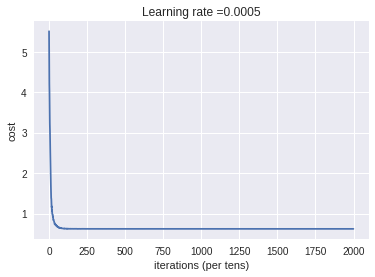

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [34]:
trained_parameters = model(X_train,Y_train,X_test,Y_test)